# Making trackpy fast(er)

This notebook explains specific features built into `trackpy` to boost performance, and it also provides some general suggestions on how to make your particle tracking run faster.

First, set up matplotlib...

In [1]:
%matplotlib inline
import matplotlib
from matplotlib.pyplot import imshow

Let's check the `trackpy` version. If it's not 0.2.0 or greater, the following may not work.

In [2]:
import trackpy
trackpy.__version__

'0.2.3-36-g98bb92c'

## General advice

### Subnets

As we'll see in the examples below, the need to resolve "subnetworks" — in which multiple neighboring particles in one frame could correspond to multiple particles in the next — can drastically slow down tracking. Subnets can be mitigated by reducing the `search_range` parameter in the linking step, though this may result in more particles that cannot be tracked. In the text below, we'll look at some methods for finding out just how much a of a problem subnets are.

### Feature-finding: The best advice

Judicious use of the `minmass` and/or `threshold` parameters during feature-finding, as described in the "walkthrough" tutorial notebook, can considerably speed up feature-finding, linking, and analysis of tracks. The best way to speed up a computation is usually to avoid doing it at all.

### Feature-finding: The details

The `locate()` and `batch()` functions for feature-finding can use either of two engines for their work, as specified by the optional `engine` parameter:

- The `numba` engine is reasonably fast. It is the default when numba is installed (see above).
- The `python` engine is currently slightly more accurate, but considerably slower.

In addition, both engines do some extra work that you might not always need:

- They iteratively try to refine the position of the feature centroid, for the best possible subpixel accuracy. This can be turned off with the parameter `max_iterations=0`.
- They compute extra data about the feature, such as its eccentricity. This can be turned off with `characterize=False`.

**Note:** Before sacrificing accuracy for performance, it's best to know objectively how much performance you are gaining. Read on to the Advanced Topics section for information about how to time feature-finding.

## Prediction

As discussed in the "prediction" tutorial, for some data it is possible to have your cake and eat it too: reduce `search_radius` to avoid subnets, but still successfully track as many particles as possible.

## Using trackpy's acceleration features

For many kinds of data, `trackpy` spends most of its computing time in just a handful of algorithms. Improving the performance of just these few bottlenecks can dramatically speed up the entire code. `trackpy` contains faster implementations of some of these algorithms, but they are optional because they depend on other software that may not be trivial to install. Making sure these components are happy can dramatically speed up `trackpy`.

## Theoretical performance diagnostics: `performance_report()`

`trackpy` provides an easy way to see which of these speedups are in effect.

In [3]:
import trackpy.diag
trackpy.diag.performance_report()

Yes, but could it be faster?
FAST: numba is available and enabled (fast subnets and feature-finding).
FAST: Using pyfftw for image preprocessing.


Let's look at each of these items in turn.

### `numba`

2 algorithms in `trackpy` can be sped up by the [`numba`](http://numba.pydata.org) array-based just-in-time compiler for Python:

- Iteratively refining the centroids of features, for better subpixel resolution.
- Resolving subnetworks, as part of the linking process.

The source code actually contains separate Python and numba versions of each. The default setting is to use the numba version when possible, but to fall back on the Python version if numba is unavailable. You can also control these choices manually, using the `engine` argument to `locate()`, and the `link_strategy` argument when linking.

If you don't have `numba`, we recommend using the Anaconda or Canopy scientific Python distributions, which include `numba` and many other useful packages.

### `pyfftw`

The bandpass filtering that prepares an image for feature-finding is done using fast Fourier transforms (FFT). The FFTW library is an exceptionally fast implementation of FFT, and `pyfftw` is the module that lets Python programs use it. Like numba, it optional, but it can speed up the bandpass operation by a factor of ~3.

You should be able to install FFTW from your Linux package manager, or on the Mac using [Homebrew](http://brew.sh) (with the command `brew install fftw`). Once you've done that, `pyfftw` itself should install with `pip install pyfftw`

## Advanced topics

### Neighbor-finding strategy: KDTree

An important operation in tracking (i.e. linking) is finding all the particles that are close to a certain point in space. `trackpy` has two ways of doing this

- A KDTree, which only handles more standard cases (e.g. Euclidean geometries) and is written in C. (This is the default.)
- A BTree hash, which is very flexible but written in pure Python and tends to be slower.

The method is set by the `neighbor_strategy` argument to the various linking functions, which again defaults to KDTree. The KDTree is a standard part of `scipy`; if you can run `trackpy` at all, it is enabled.

### Empirical performance diagnostics: Timing and profiling

What follows is a crash course in how to evaluate the performance of tracking. The general suggestions given above are good starting points, but they are just that — general suggestions. For your *specific* application, you need *specific* data about how long the computation takes, and how the computer is spending its time. This information may help you make your own adjustments to your tracking method, or it may help you when asking the `trackpy` developers for assistance (chances are we'll be happy to help!).

You will use these techniques with your own data, but let's use the data from the "walkthrough" tutorial.

### Setup

In [4]:
import trackpy as tp

In [5]:
def gray(image):
    return image[:, :, 0]

frames = tp.ImageSequence('../sample_data/bulk_water/*.png', process_func=gray)

The speed at which we can read images from disk is not something we can hope to improve much, so let's get that out of the way before we do our tests. Also, we don't need to use all the frames for this example (though you're welcome to).

In [6]:
# This gets the image data out of the pims ImageSequence object, and into a good old list in memory.
frames_preload = list(frames[:50])

Just so we don't forget what these images look like:

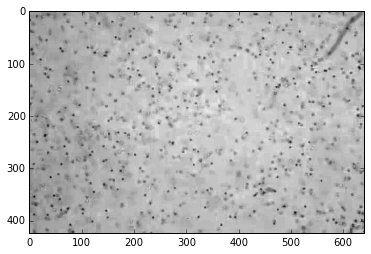

In [7]:
imshow(frames_preload[0], cmap=matplotlib.cm.gray)

Before we identify features, we need to give `trackpy` a chance to "warm up" — initialize `fftw` and compile certain functions, if it hasn't done so already. So we'll find features in just 2 frames: 

In [8]:
f2 = tp.batch(frames_preload[:3], 11, minmass=2000, invert=True)

Frame 2: 432 features


### Timing

Let's find out — precisely — how long it takes to find features in a single frame. You'll notice that the following cell begins with the line `%%timeit`. This is an example of a *cell magic*, which gives IPython special instructions about how to run the rest of the cell.

In [9]:
%%timeit
f1 = tp.batch(frames_preload[:1], 11, minmass=2000, invert=True)

Frame 0: 438 features
1 loops, best of 3: 365 ms per loop


`%%timeit` runs the same code multiple times and returns a somewhat accurate measurement of execution time. We can use it to see how much faster we can find features in this image when we turn off centroid refinement and feature characterization:

In [10]:
%%timeit
f1 = tp.batch(frames_preload[:1], 11, minmass=2000, invert=True, 
              max_iterations=0, characterize=False)

Frame 0: 435 features
1 loops, best of 3: 243 ms per loop


One thing to note is that the ratio of features to pixels is rather low in this image. If you were finding features in a dense packing of particles, the timing difference could be much more significant.

### Profiling

Next, we'll try to get a sense of what's taking so long. The `%%prun` cell magic instructs IPython to run the rest of the cell's code using a *profiler*.

In [11]:
%%prun
f = tp.batch(frames_preload, 11, minmass=2000, invert=True)

Frame 49: 442 features
 

When execution is complete, a pager will pop up in the lower portion of the notebook window. This is the profiler output. We reproduce a portion of it here. Your results will depend on your data and the computer you are using.


    721076 function calls (719979 primitive calls) in 14.295 seconds

    Ordered by: internal time

    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        50    3.949    0.079    3.949    0.079 {scipy.ndimage._nd_image.min_or_max_filter}
       200    2.855    0.014    3.006    0.015 _utils.py:29(_Xfftn)
        50    0.917    0.018    0.917    0.018 {scipy.ndimage._nd_image.binary_erosion}
       150    0.828    0.006    0.828    0.006 {numpy.core.multiarray.where}
        50    0.741    0.015    6.211    0.124 feature.py:21(local_maxima)
       200    0.670    0.003    0.670    0.003 {scipy.ndimage._nd_image.uniform_filter1d}
     24345    0.621    0.000    1.098    0.000 feature.py:71(estimate_mass)
     53750    0.555    0.000    0.556    0.000 {method 'reduce' of 'numpy.ufunc' objects}
     27957    0.383    0.000    0.820    0.000 _methods.py:49(_mean)
       100    0.282    0.003    5.185    0.052 preprocessing.py:34(bandpass)
       100    0.271    0.003    0.271    0.003 {scipy.ndimage._nd_image.fourier_filter}
        50    0.191    0.004   14.152    0.283 feature.py:400(locate)
        50    0.176    0.004    0.176    0.004 {method 'sort' of 'numpy.ndarray' objects}
       100    0.174    0.002    0.174    0.002 {method 'nonzero' of 'numpy.ndarray' objects}
       151    0.108    0.001    0.108    0.001 {method 'query_pairs' of 'scipy.spatial.ckdtree.cKDTree' objects}

This is a record of how the computer spent its time while finding features. The various numbers are explained in the [documentation for the Python `profiler` module](http://docs.python.org/2/library/profile.html#instant-user-s-manual). You shouldn't try to understand every line, but you can get some idea of which functions are called for each frame (multiples of 50), and which are called for each particle. Note that `{functions in braces}` are written in C, not Python, are not part of `trackpy`, and tend to be less user-serviceable.

Now let's look at the linking step. Once again, we'll prime `trackpy`, to avoid distorting our results with one-time setup code:

In [12]:
# Use a large search_range, to be sure that numba subnet code is compiled and used.
t1 = tp.link_df(f2, 10, memory=3)

Frame 2: 432 trajectories present


In [13]:
%%prun
t = tp.link_df(f, 5, memory=3)

Frame 49: 442 trajectories present
 

    1379151 function calls (1378749 primitive calls) in 2.557 seconds

    Ordered by: internal time

    ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        51    0.209    0.004    2.129    0.042 linking.py:614(link_iter)
     19596    0.207    0.000    0.927    0.000 series.py:126(__init__)
     19443    0.122    0.000    0.253    0.000 series.py:2490(_sanitize_array)
    248849    0.109    0.000    0.114    0.000 {isinstance}
       400    0.108    0.000    1.399    0.003 {map}
       539    0.093    0.000    0.114    0.000 linking.py:1062(numba_link)
     41310    0.092    0.000    0.093    0.000 {numpy.core.multiarray.array}
     19646    0.088    0.000    0.267    0.000 internals.py:3571(__init__)
     19091    0.074    0.000    0.949    0.000 frame.py:507(iterrows)
     19902    0.071    0.000    0.153    0.000 internals.py:1944(make_block)
     19041    0.065    0.000    0.310    0.000 linking.py:598(<lambda>)
        49    0.063    0.001    0.170    0.003 linking.py:871(assign_candidates)

This goes much faster than feature identification, though to be fair, we have far, far more pixels than particles. Note the calls to `numba_link`; this is the subnet resolution code referred to above. If you require a large `search_range`, these computations can dramatically slow down linking. As it is, they are under control.

Well, I hope you've enjoyed this brief tour of `trackpy` performance. Just remember that if you come up with new ways to improve performance, the `trackpy` community will be very interested!